In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


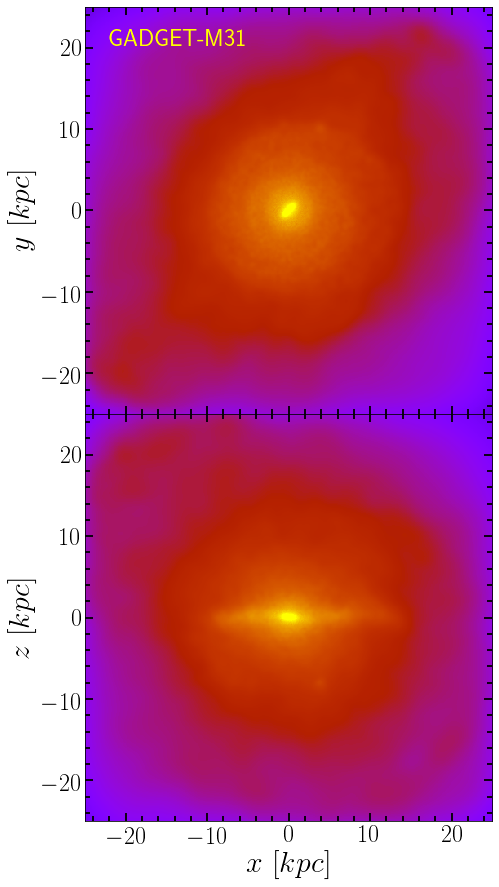

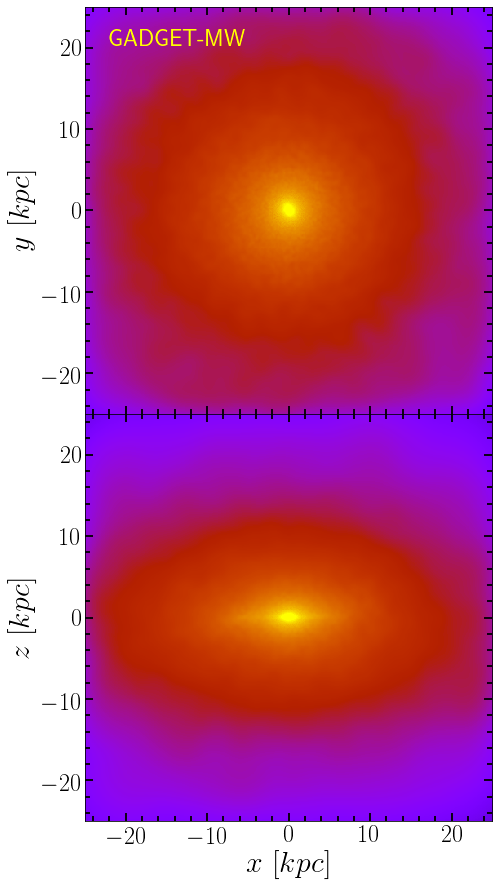

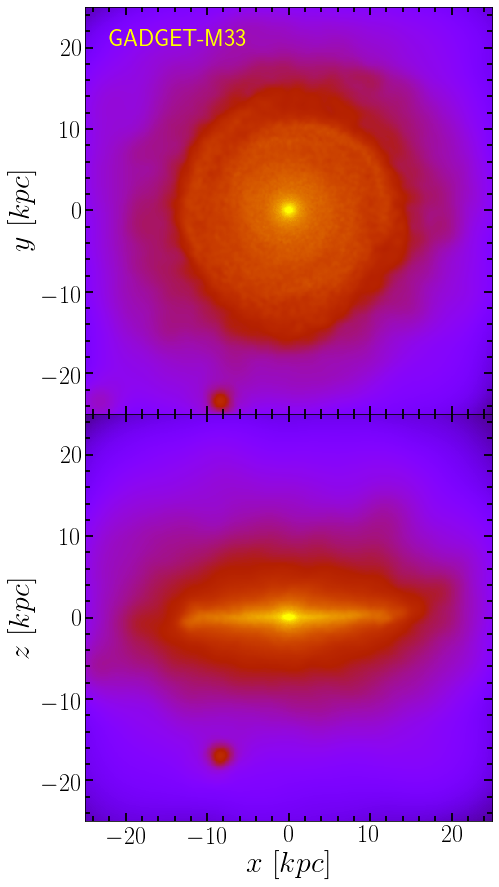

In [2]:
import h5py
import rotation as rot
import sphviewer as sph
from __future__ import unicode_literals
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_497.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    z = a0/aexp - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp/h
    ystr = (pstr[:,1]-cm[1])*aexp/h
    zstr = (pstr[:,2]-cm[2])*aexp/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=25   
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,13))
    fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0.03, hspace= 0)

    particles=sph.Particles(pos[:,corte],masa_str[corte]*1e10,nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(211)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
    ax1.set_xticklabels([])
    #plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=30)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=24)
    ax1.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
    ax1.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
    plt.text(-22, 21,'GADGET-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
    #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
    #              ha='center', va='center', 
    #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))

    #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')


    particles=sph.Particles(pos[:,corte],masa_str[corte]*1e10,nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax2=fig.add_subplot(212)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    plt.xlabel('$x$'+' $[kpc]$', fontsize=30)
    plt.ylabel('$z$'+' $[kpc]$', fontsize=30)
    ax2.minorticks_on()
    ax2.tick_params( labelsize=24)
    ax2.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
    ax2.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
    #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 


#     fig.savefig('/home/ornela/python/sem1/M31_3/'+str('%03d'%isnap)+'-sh0'+str('%s'%vector[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
#     fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/starGD_'+str('%s'%vector2[i])+'.png', dpi = 100)
#     fig.savefig('/home/ornela/Salidas/starGD_'+str('%s'%vector2[i])+'.png', dpi = 100)
    plt.show()
    #plt.clf()


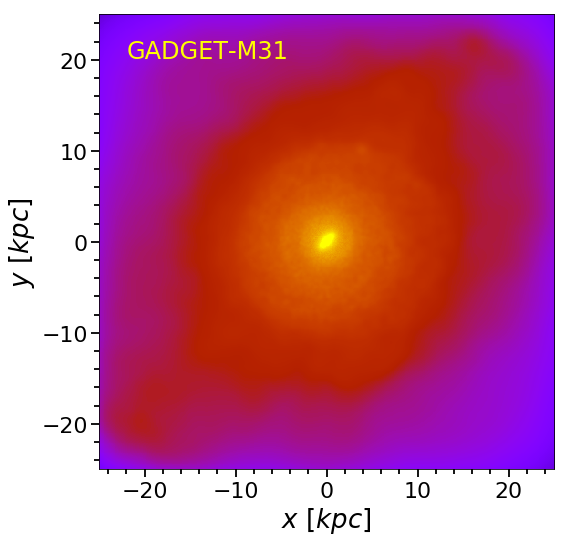

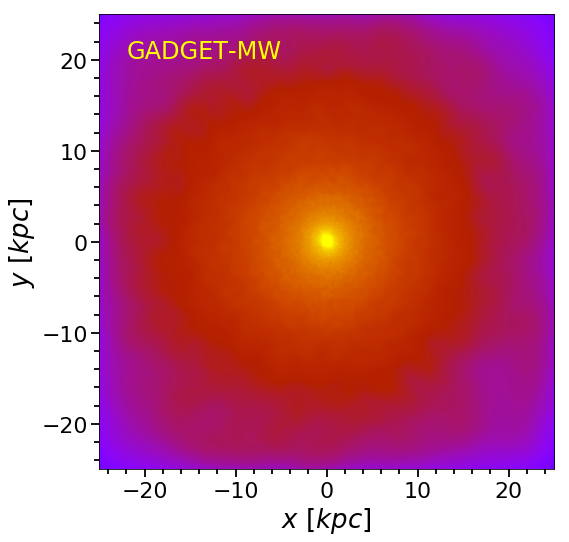

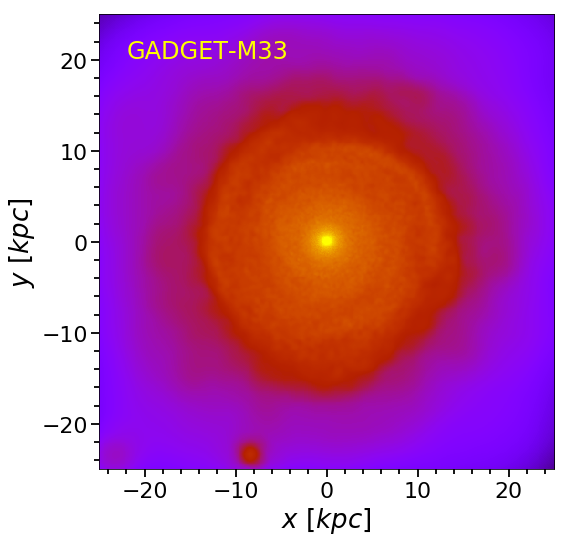

In [10]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_496.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value

    pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    z = a0/aexp - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp/h
    ystr = (pstr[:,1]-cm[1])*aexp/h
    zstr = (pstr[:,2]-cm[2])*aexp/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=25   
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

    particles=sph.Particles(pos[:,corte],masa_str[corte]*1e10,nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(111)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
    #ax1.set_xticklabels([])
    plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=22)
    ax1.tick_params('both', length=5, width=1.8,which='minor')
    ax1.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-22, 21,'GADGET-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center')
    #plt.text(-4.5, 4.3,'GADGET-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
    #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
    #              ha='center', va='center', 
    #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))

    #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')


    
    fig.savefig('/home/ornela/SAN2017/starGD_'+str('%s'%vector2[i])+'.png', dpi = 100)
    plt.show()
    #plt.clf()

In [2]:
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time


In [3]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

aa = np.loadtxt('/home/ornela/python/ornella/redshift_outputs.txt')
aexp = aa[:,2]

snapshot=range(496,171,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    #print isnap
    
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    #aexp = snap['subhalo_000/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    z = a0/aexp[isnap] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)
#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[isnap]/h
    ystr = (pstr[:,1]-cm[1])*aexp[isnap]/h
    zstr = (pstr[:,2]-cm[2])*aexp[isnap]/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[isnap]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[isnap]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[isnap]) + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp[isnap]/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    #if isnap == 497:
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,2*r50[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=5   
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=6

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

    particles=sph.Particles(pos[:,corte],masa_str[corte]*1e10,nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(111)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
    #ax1.set_xticklabels([])
    #ax1.set_yticklabels([])
    plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=30)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=24)
    ax1.tick_params('both', length=5, width=1.8,which='minor')
    ax1.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-4.8,4.5,'GADGET-M31', fontsize=24, color='yellow', ha='left', va='center') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
#         plt.annotate("",xy=(7, -14), xycoords='data',xytext=(12, -14),textcoords='data',
#                       ha='center', va='center', 
#                      arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

    #plt.text(9.5, -14, '5 kpc', fontsize=24, color='white', ha='center', va='bottom')
    plt.text(-4.5, -4.5, str('%.3f'%t)+'Gyr', fontsize=24, color='white', ha='left', va='center')


    '''particles=sph.Particles(pos[:,corte],masa_str[corte]*1e10,nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax2=fig.add_subplot(212)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    plt.xlabel('$x$'+' $[kpc]$', fontsize=30)
    plt.ylabel('$z$'+' $[kpc]$', fontsize=30)
    ax2.minorticks_on()
    ax2.tick_params( labelsize=24)
    ax2.tick_params('both', length=5, width=1.8,which='minor')
    ax2.tick_params('both', length=8, width=1.8,which='major')
    #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top')''' 


    #fig.savefig('/home/ornela/python/sem2/M31_str4/'+str('%03d'%isnap)+'-M31.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
    #fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/starGD_'+str('%s'%vector2[i])+'.png', dpi = 100)
    #fig.savefig('/home/ornela/python/sem2/M31_str4/'+str('%03d'%isnap)+'-M31.png', dpi=100)
    fig.savefig('/home/ornela/python/sem2/M31_str6/'+str('%03d'%isnap)+'-M31.png', dpi=100)
    #plt.show()
    plt.clf()

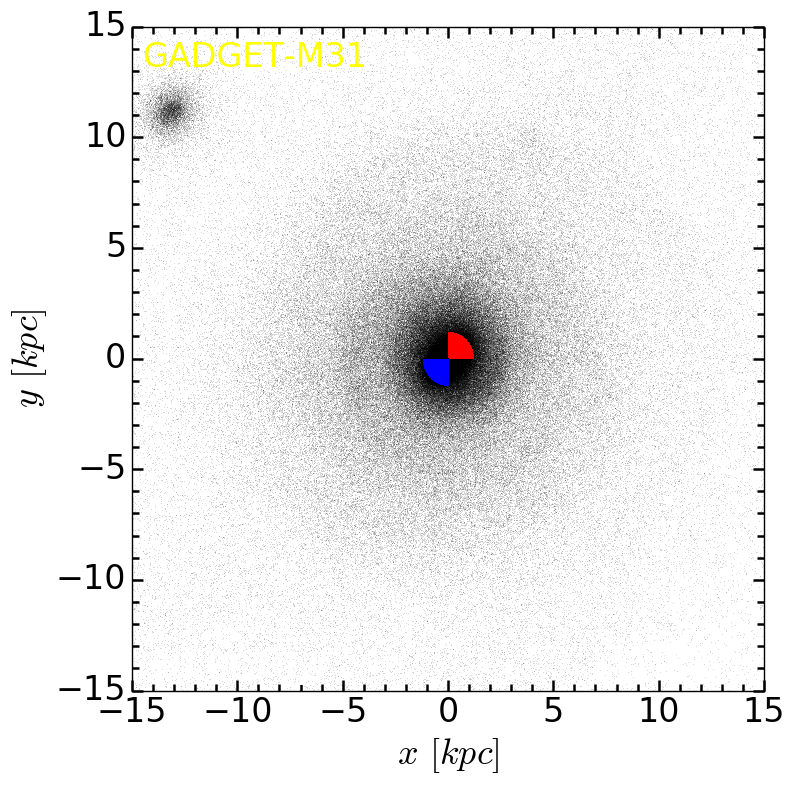

In [7]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    #print isnap
    for i in range(0,1):
        cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
        

        pstr = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        IDs = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Ids'].value
        masa_str = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_0'+ str('%s' %vector[i])+ '/Str/Velocities'].value

        z = a0/aexp - 1.
        Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
        t = tiempo.conv(z, h, omega_lambda, omega_matter)
    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = (pstr[:,0]-cm[0])*aexp/h
        ystr = (pstr[:,1]-cm[1])*aexp/h
        zstr = (pstr[:,2]-cm[2])*aexp/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
        v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
        v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.

    #----------------------masas----------------------------
        masa_str = masa_str/h

        r200 = r200*aexp/h
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                

    #------------------masa total en r200 (Mvir)--------------------------         
        corte,=np.where(r<r90[-1])
        veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
        if isnap == 497:
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz
        
        Rcirc = np.sqrt(xn**2+yn**2)
        mask, = np.where((Rcirc<1.2) & (xn >0) & (yn >0))
        mask2, = np.where((Rcirc<1.2) & (xn <0) & (yn <0))
        
        IDred = IDs[mask]
        IDblue = IDs[mask2]
        
        
        fig=plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
        ax1=fig.add_subplot(111)
        ax1.plot(xn,yn,'.', markersize=0.1, color='k')
        ax1.plot(xn[mask],yn[mask],'.', markersize=0.5, color='r')
        ax1.plot(xn[mask2],yn[mask2],'.', markersize=0.5, color='b')
        #plt.axis('off')
        #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
        #ax1.set_xticklabels([])
        #ax1.set_yticklabels([])
        ax1.set_xlim(-15,15)
        ax1.set_ylim(-15,15)
        plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
        ax1.minorticks_on()
        ax1.tick_params( labelsize=24)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')
        plt.text(-14.5, 13.6,'GADGET-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
                 #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
        plt.annotate("",xy=(7, -14), xycoords='data',xytext=(12, -14),textcoords='data',
                      ha='center', va='center', 
                     arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

        plt.text(9.5, -14, '5 kpc', fontsize=24, color='white', ha='center', va='bottom')
        plt.text(-14, -14, str('%.3f'%t)+'Gyr', fontsize=24, color='white', ha='left', va='center')


        #fig.savefig('/home/ornela/python/sem2/M31_str2/'+str('%03d'%isnap)+'-M31.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
        #fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/starGD_'+str('%s'%vector2[i])+'.png', dpi = 100)
        plt.show()
        #plt.clf()
        
        

In [8]:
print len(IDblue), len(IDred)

72349 72279


<function matplotlib.pyplot.show>

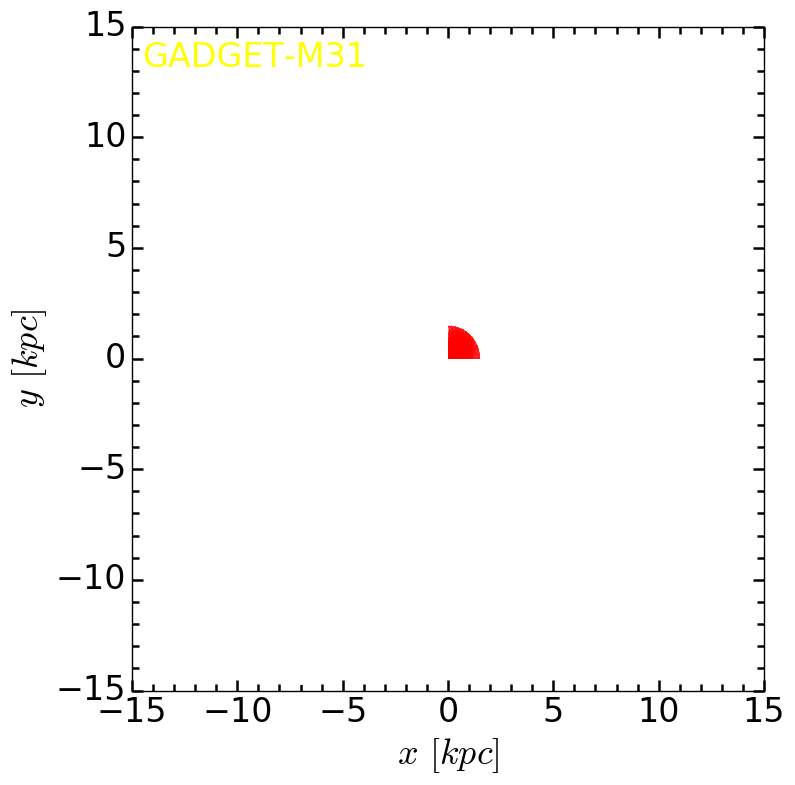

In [4]:
fig=plt.figure(1,figsize=(8,8))
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
ax1=fig.add_subplot(111)
#ax1.plot(xn1,yn1,'.', markersize=0.1, color='k')
for ii in IDred:
    REDid = np.where(ii == IDs)
    ax1.plot(xn[REDid],yn[REDid],'.', markersize=0.1, color='r')
    #BLUEid = np.argwhere(ii == IDblue)
    #ax1.plot(xn[BLUEid],yn[BLUEid],'.', markersize=0.1, color='b')
ax1.set_xlim(-15,15)
ax1.set_ylim(-15,15)
plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
ax1.minorticks_on()
ax1.tick_params( labelsize=24)
ax1.tick_params('both', length=5, width=1.8,which='minor')
ax1.tick_params('both', length=8, width=1.8,which='major')
plt.text(-14.5, 13.6,'GADGET-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
         #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
plt.annotate("",xy=(7, -14), xycoords='data',xytext=(12, -14),textcoords='data',
              ha='center', va='center', 
             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

plt.text(9.5, -14, '5 kpc', fontsize=24, color='white', ha='center', va='bottom')
plt.text(-14, -14, str('%.3f'%t)+'Gyr', fontsize=24, color='white', ha='left', va='center')
plt.show

In [ ]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import numpy as np
import time_conversion as tiempo

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

snapshot=range(496,493,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')
    #print isnap
    cm   = snap['subhalo_000/Center'].value
    r200 = snap['subhalo_000/R200'].value
    aexp = snap['subhalo_000/Time'].value

    pstr = snap['subhalo_000/Str/Coordinates'].value
    IDs = snap['subhalo_000/Str/Ids'].value
    masa_str = snap['subhalo_000/Str/Masses'].value
    vel  = snap['subhalo_000/Str/Velocities'].value

    z = a0/aexp - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)
    t = tiempo.conv(z, h, omega_lambda, omega_matter)
#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp/h
    ystr = (pstr[:,1]-cm[1])*aexp/h
    zstr = (pstr[:,2]-cm[2])*aexp/h
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp) + Ht *zstr/1000.

#----------------------masas----------------------------
    masa_str = masa_str/h

    r200 = r200*aexp/h
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]          
#------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    if isnap == 497:
        e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    
    print 'Red is the best'
    
    fig=plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)
    ax=fig.add_subplot(111)
    ax.plot(xn,yn,'.', markersize=0.1, color='k')
    for ii in IDred:
        aux = np.where(ii == IDs)
        ax.plot(xn[aux],yn[aux],'.', markersize=0.1, color='r')
    print 'I am blue'
    for ii in IDblue:
        aux = np.where(ii == IDs)
        ax.plot(xn[aux],yn[aux],'.', markersize=0.1, color='b')
    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_xlabel('$x$'+' $[kpc]$', fontsize=26)
    ax.set_ylabel('$y$'+' $[kpc]$', fontsize=26)
    ax.minorticks_on()
    ax.tick_params( labelsize=24)
    ax.tick_params('both', length=5, width=1.8,which='minor')
    ax.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-14.5, 13.6,'GADGET-'+'%s'%vector2[i], fontsize=24, color='k', ha='left', va='center') 
    plt.annotate("",xy=(7, -14), xycoords='data',xytext=(12, -14),textcoords='data',
                  ha='center', va='center', 
                 arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='k', lw=2.5))
    plt.text(9.5, -14, '5 kpc', fontsize=24, color='k', ha='center', va='bottom')
    plt.text(-14, -14, str('%.3f'%t)+'Gyr', fontsize=24, color='k', ha='left', va='center')
    #fig.savefig('/home/ornela/python/sem2/M31_str2/'+str('%03d'%isnap)+'-M31.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
    plt.show()
    #plt.clf()



Red is the best
I am blue


In [6]:
array = np.array([3,4,5,6])
print array
m, = np.where(4 == array)
print m
print array[m]

[3 4 5 6]
[1]
[4]


In [12]:
np.where(IDred == -2140377565)

(array([2]),)

In [3]:
import h5py

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter
vector2 = ('M31','MW','M33')
vector = ('00','01','03')

snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_496.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
    aexp = snap['subhalo_0'+ str('%s' %vector[i])+ '/Time'].value
    
    cm = cm*aexp/h
   
    archivo1 =  open('/home/ornela/Escritorio/center.dat','a')
    archivo1.write(str('%12.6f'% cm[0]) +'\t'+
                   str('%12.6f'% cm[1]) +'\t'+
                   str('%12.6f'% cm[2]) +'\n')
    archivo1.close()
    